Here I'd like to analyze series related to air pollution and build forecating using such ordinary models as:

SARIMA, Exponential smoothing, library prophet from Facebook and LSTM, BiLSTM 

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from tqdm.notebook import tqdm
import os
import warnings
import itertools

#get my written functions
from userfuncs import find_borders_nan_intervals, count_frequency, print_count_missing, get_metrics

from pmdarima.arima import auto_arima
import statsmodels.api as sm

import textwrap3

In [2]:
SEED = 42
sns.set(style='darkgrid')

### Preparation

In [3]:
path = os.path.join('data', 'best_ts.csv')
ts = pd.read_csv(path)

ts = ts.set_index(pd.DatetimeIndex(ts['time']))
ts = ts.drop(['time'], axis=1)
ts.columns = ['y']

ts.head(3)

,y
time,
1986-06-01,7.1
1986-06-02,5.7
1986-06-03,NaN


In [4]:
freq_ix = pd.infer_freq(ts.index)
if freq_ix is None:
    message = "Frequency of index cannot be recognized so resample a time series to daily series since the series\
 is supposed to be daily one. I will work with it.\nMy hypothesis: data is out due to some human factors and in\
 real it should be filled\n(maybe a person forgot to fill value for the certain days)"
    print(textwrap3.dedent(message))
    #it's used to only reset index to daily one
    #ts_daily = pd.DataFrame(data=ts['y'].values, columns=['y'])
    #ts_daily = ts_daily.set_index(pd.date_range(ts.index[0], periods=ts.shape[0], freq='D'))
    print(f'\nNumber of objects was: {ts.shape[0]}')
    ts_resample = pd.Series(ts['y']).resample('D')
    print(f'Number of objects is now: {ts_resample.interpolate().shape[0]}')
else:
    ts.index.freq = freq_ix

Frequency of index cannot be recognized so resample a time series to daily series since the series is supposed to be daily one. I will work with it.
My hypothesis: data is out due to some human factors and in real it should be filled
(maybe a person forgot to fill value for the certain days)

Number of objects was: 11320
Number of objects is now: 11445


**Recall how missed values are actually distributed**

In [5]:
borders_nans = find_borders_nan_intervals(ts, 'y')
missing_freq = count_frequency([x[2] for x in borders_nans])

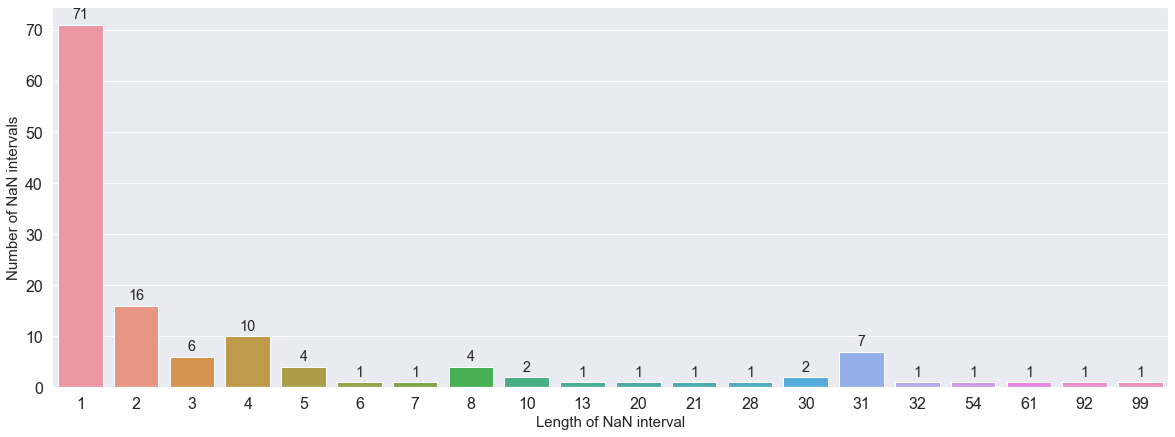

In [170]:
fig = plt.figure(figsize=(20, 7))
sbar = sns.barplot([m[0] for m in missing_freq], [m[1] for m in missing_freq])
for p in sbar.patches:
    sbar.annotate(int(p.get_height())
                  , (p.get_x() + p.get_width() / 2, p.get_height())
                  , ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points'
                  , fontsize='large')

plt.ylabel('Number of NaN intervals', fontsize=15)
plt.xlabel('Length of NaN interval', fontsize=15)
plt.tick_params(labelsize=16)
plt.show()

NaN interval is like [1, 2, nan, nan, 3, 10] 

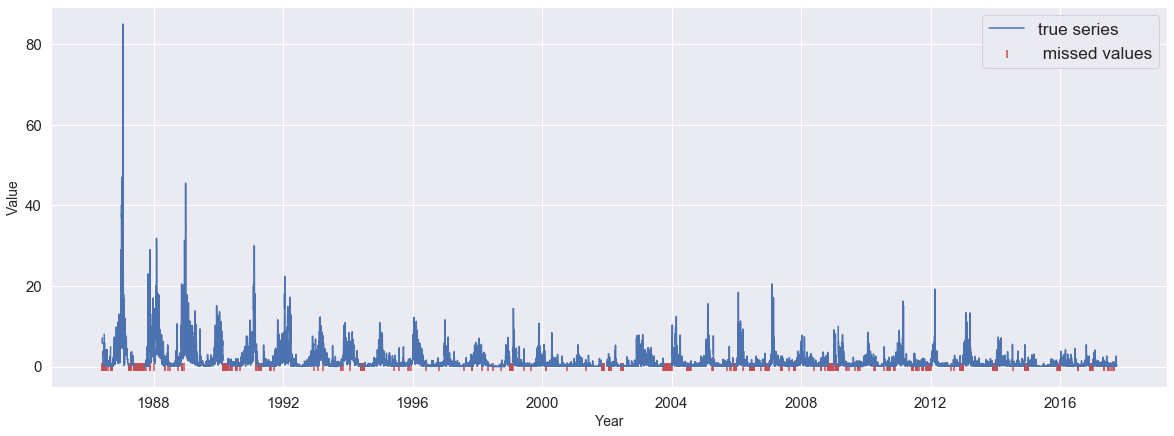

In [7]:
fig = plt.figure(figsize=(20, 7))
plt.plot(ts.index, ts['y'], label='true series')
plt.scatter(ts.index, np.where(ts['y'].isna(), 1e-5, np.nan), color='r', label=f" missed values",  marker='|', s=50)
plt.legend(loc='best', fontsize='x-large')
plt.ylabel('Value', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.tick_params(labelsize=15)
plt.show()

### Fill missing values in time series

**Interpolation**

In [8]:
ts = pd.DataFrame(ts_resample.interpolate('time'))

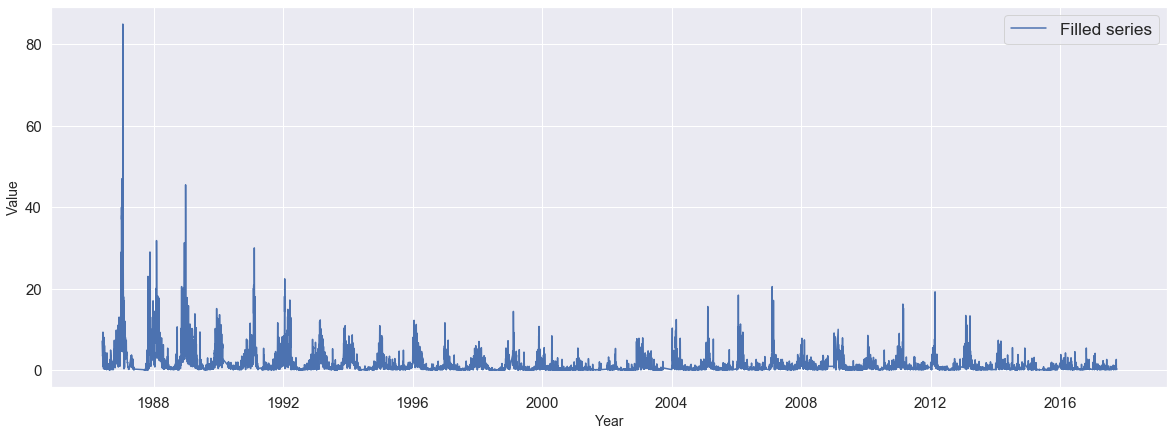

In [9]:
plt.figure(figsize=(20, 7))
plt.plot(ts.index, ts['y'], label='Filled series')
plt.legend(loc='best', fontsize='x-large')
plt.ylabel('Value', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.tick_params(labelsize=15)
plt.show()

### Look at some useful graphs

**Boxplot**

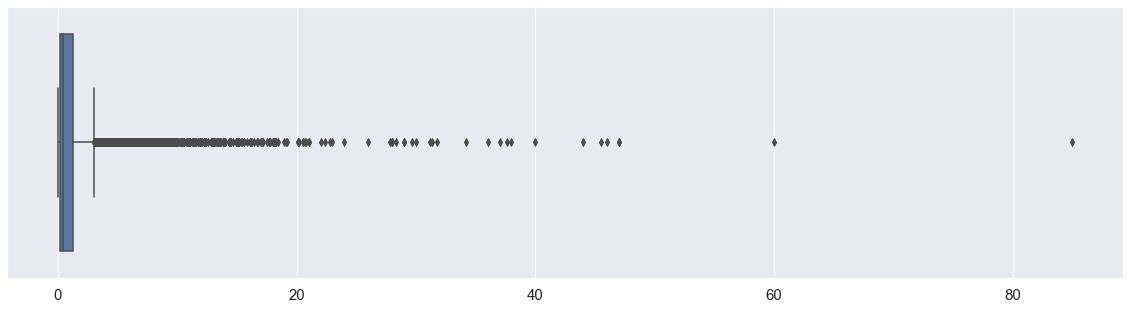

In [10]:
plt.figure(figsize=(20,5))
sns.boxplot(ts)
plt.tick_params(labelsize=15)
plt.show()

**Distribution**

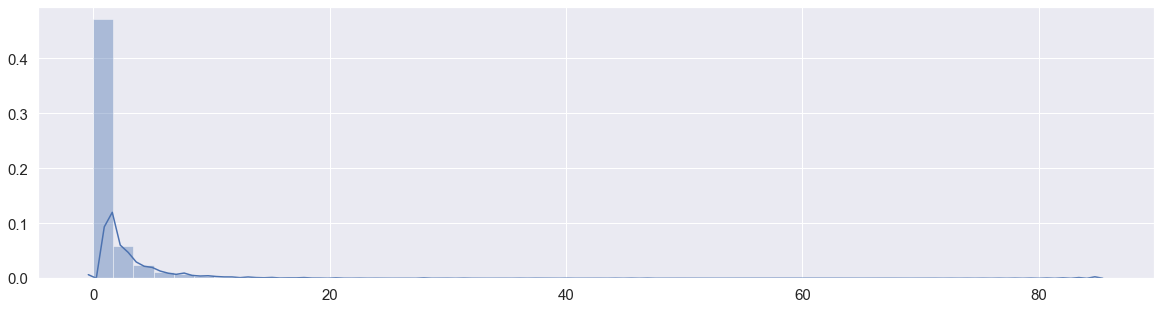

In [11]:
plt.figure(figsize=(20,5))
sns.distplot(ts)
plt.tick_params(labelsize=15)
plt.show()

We can see that a real big value in the begining of the series impact on distribution. But it's hard for me to say if it's an outlier or a real value in that time. I'd suppose a real one

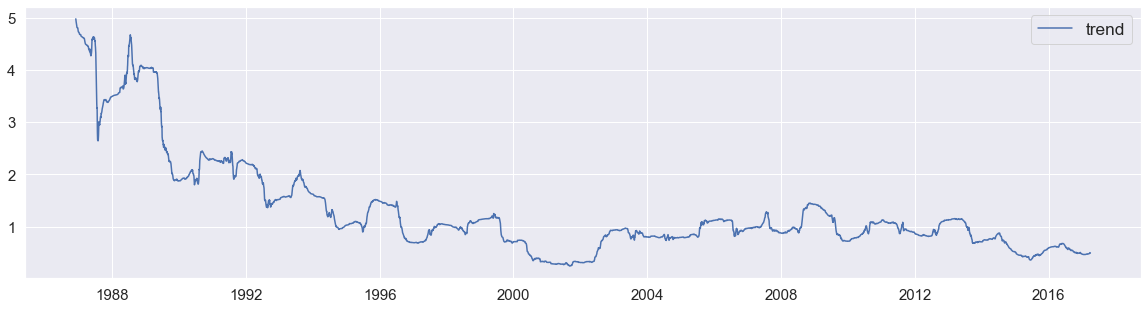

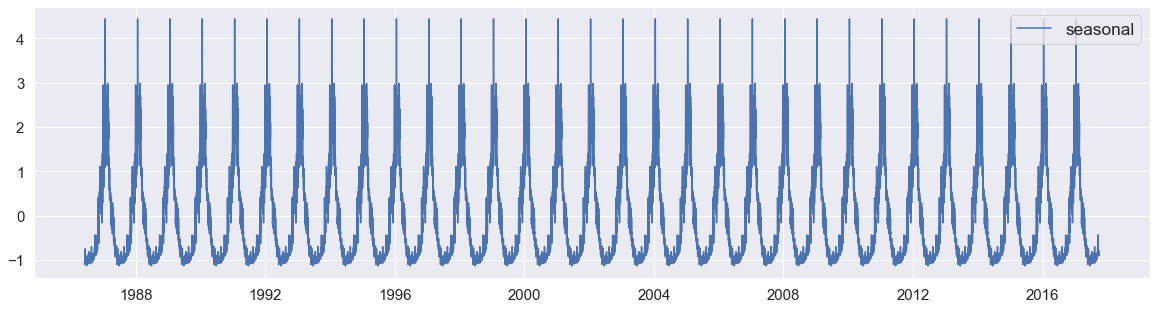

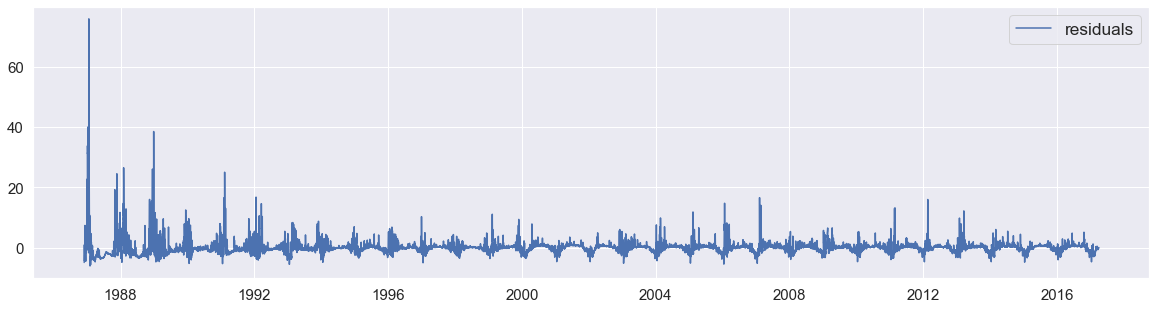

In [12]:
decomp = sm.tsa.seasonal_decompose(ts['y'], period=365)
plt.figure(figsize=(20,5))
plt.plot(decomp.trend, label='trend')
plt.legend(loc='best', fontsize='x-large')
plt.tick_params(labelsize=15)

plt.figure(figsize=(20,5))
plt.plot(decomp.seasonal, label='seasonal')
plt.legend(loc='best', fontsize='x-large')
plt.tick_params(labelsize=15)

plt.figure(figsize=(20,5))
plt.plot(decomp.resid, label='residuals')
plt.legend(loc='best', fontsize='x-large')
plt.tick_params(labelsize=15)

plt.show()

Series is of course non-stationary

## Monthly data

Since there're too much data I'd like to aggregate it by month using averaging. 'Maximum' seems to be useful too since we can be interested in limit values in this case (air pollution).

Also it seems quite legal to use data after 2000 year since it doesn't mean too much what was before. Also, as I know ARIMA works well when there's no too much data (maybe about 200 is enough).
<br>
But for neural networks larger size of series can be better.

In [13]:
ts_monthly = ts.resample('M').mean()
print(f"Number of elements in daily series: {ts.shape[0]}")
print(f"Number of elements in monthly series: {ts_monthly.shape[0]}")
#create copy of monthly data for all period
ts_monthly_copy = ts_monthly.copy()

Number of elements in daily series: 11445
Number of elements in monthly series: 376


In [14]:
start_date = pd.to_datetime('2000/01/01', format='%Y/%m/%d')
ts_monthly = ts_monthly[ts_monthly.index >= start_date]
print(f'Number of values in series after {str(start_date).split()[0]}: {ts_monthly.shape[0]}')

Number of values in series after 2000-01-01: 213


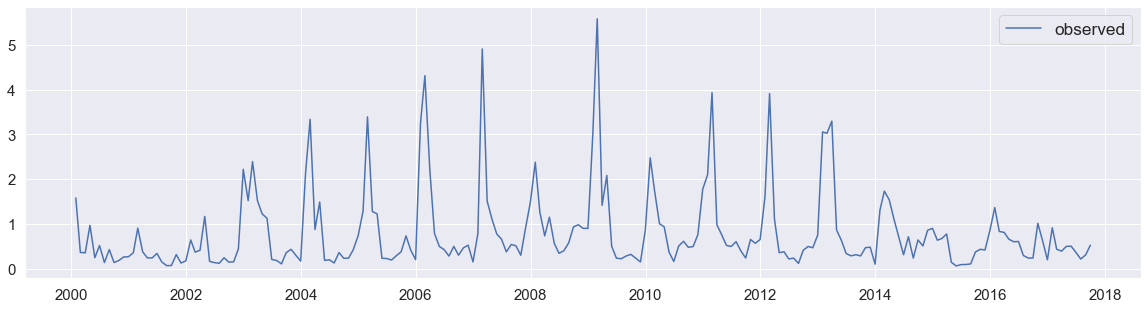

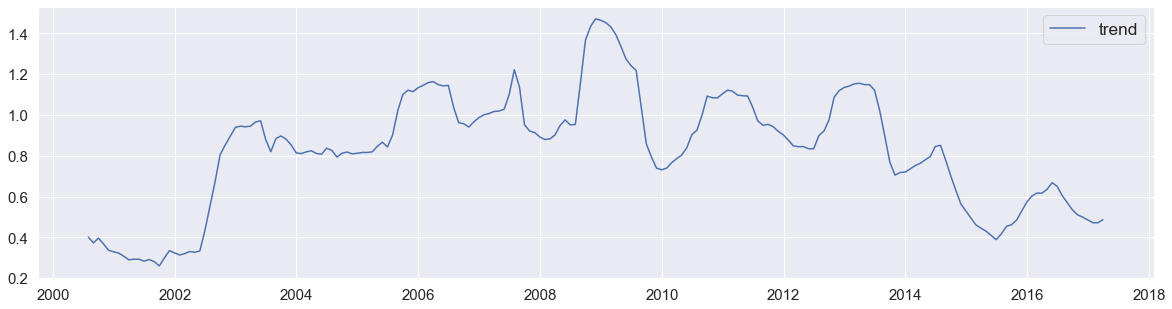

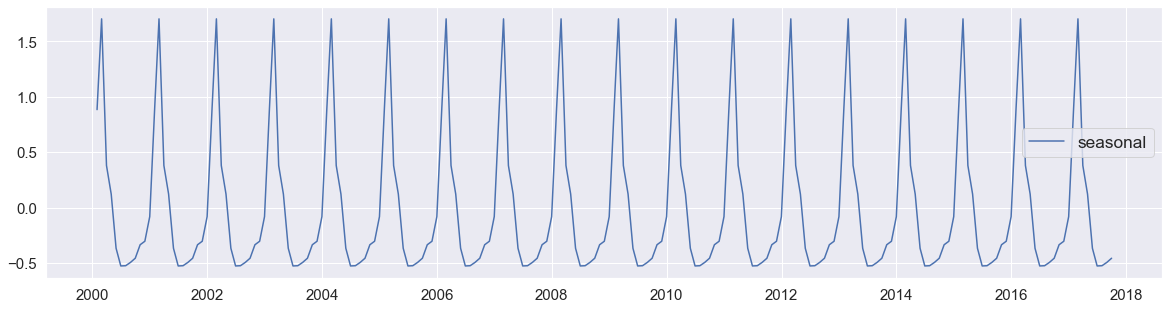

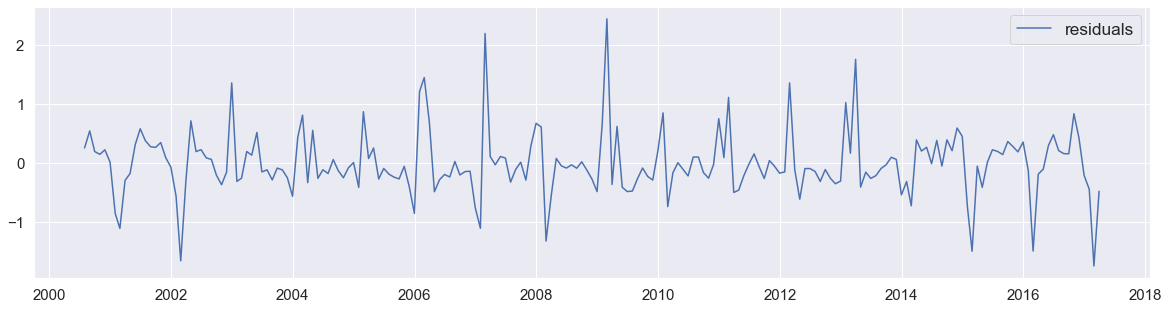

In [15]:
decomp = sm.tsa.seasonal_decompose(ts_monthly, period=12)

plt.figure(figsize=(20,5))
plt.plot(decomp.observed, label='observed')
plt.legend(loc='best', fontsize='x-large')
plt.tick_params(labelsize=15)

plt.figure(figsize=(20,5))
plt.plot(decomp.trend, label='trend')
plt.legend(loc='best', fontsize='x-large')
plt.tick_params(labelsize=15)

plt.figure(figsize=(20,5))
plt.plot(decomp.seasonal, label='seasonal')
plt.legend(loc='best', fontsize='x-large')
plt.tick_params(labelsize=15)

plt.figure(figsize=(20,5))
plt.plot(decomp.resid, label='residuals')
plt.legend(loc='best', fontsize='x-large')
plt.tick_params(labelsize=15)

plt.show()

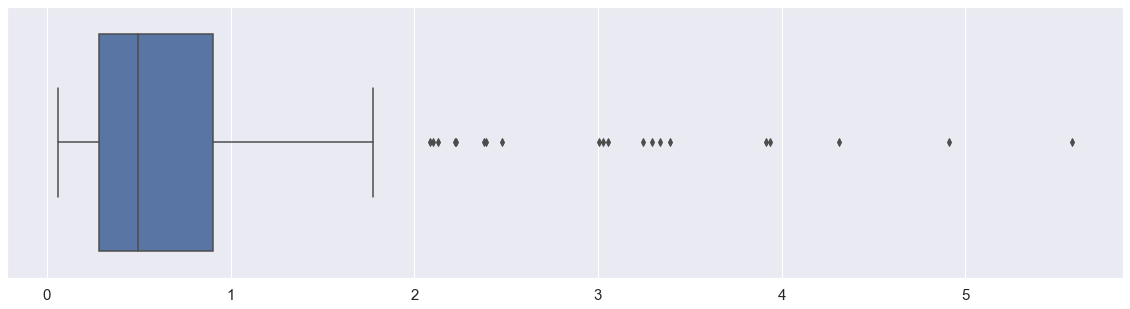

In [16]:
plt.figure(figsize=(20,5))
sns.boxplot(ts_monthly)
plt.tick_params(labelsize=15)
plt.show()

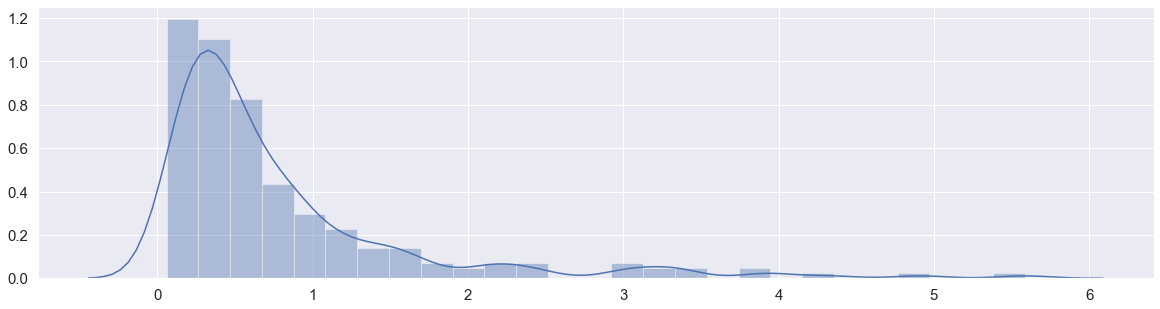

In [17]:
plt.figure(figsize=(20,5))
sns.distplot(ts_monthly)
plt.tick_params(labelsize=15)
plt.show()

## Modeling

use monthly data

I'll predict 2 periods of seasons ahead, so it'll be my test series

In [18]:
PERIODS = 12
PREDICTIONS = 2 * PERIODS
ALPHA = 0.05 #to check hypothesis

In [19]:
#create dict to save metrics from different models
metrics_d = {}
#cread dataframe to save forecasted data from different models
forecast_df = pd.DataFrame(columns=['actual', 'prophet', 'sarima', 'auto_sarima'
                                    , 'holt-winters', 'lstm', 'bilstm']
                       , index=list(range(PREDICTIONS)))

### Prophet

simple one

In [20]:
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [21]:
df_prop = pd.DataFrame({'ds': ts_monthly.index, 'y': ts_monthly['y'].values})

train = df_prop[:-PREDICTIONS]
test = df_prop[-PREDICTIONS:]
#save actual values (only one time it's needed)
forecast_df['actual'] = test['y'].to_numpy()

In [22]:
model_prop = Prophet(seasonality_mode='multiplicative', weekly_seasonality=False, daily_seasonality=False)
model_prop.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [23]:
forecast = model_prop.predict(test)
yhat_prop = forecast['yhat']
#save to forecast df
forecast_df['prophet'] = yhat_prop

In [24]:
l = {}
for k, v in get_metrics(test['y'].to_numpy(), yhat_prop).items():
    print(f"{k}: {v}")
    l[k] = v
metrics_d['prophet'] = l

RMSE: 0.3799678271543013
MAE: 0.2802614613452549
MAPE: 0.5379096638514238


**Save model**

In [25]:
joblib.dump(model_prop, os.path.join('models', 'prophet.pkl'))
#joblib.load(os.path.join('models', 'prophet.pkl'))

['models/prophet.pkl']

### SARIMA

Parameters can be found using auto_arima from statsmodels (it is particularly convenient if there are lots of series) but here i'll do it by hand

In [26]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [159]:
train = ts_monthly[:-PREDICTIONS]
test = ts_monthly[-PREDICTIONS:]

Box Cox

I use Box Cox transformation to reduce variance in data

In [161]:
y_box, LMBDA = stats.boxcox(train.loc[:, 'y'])
train.loc[:, 'y_box'] = y_box

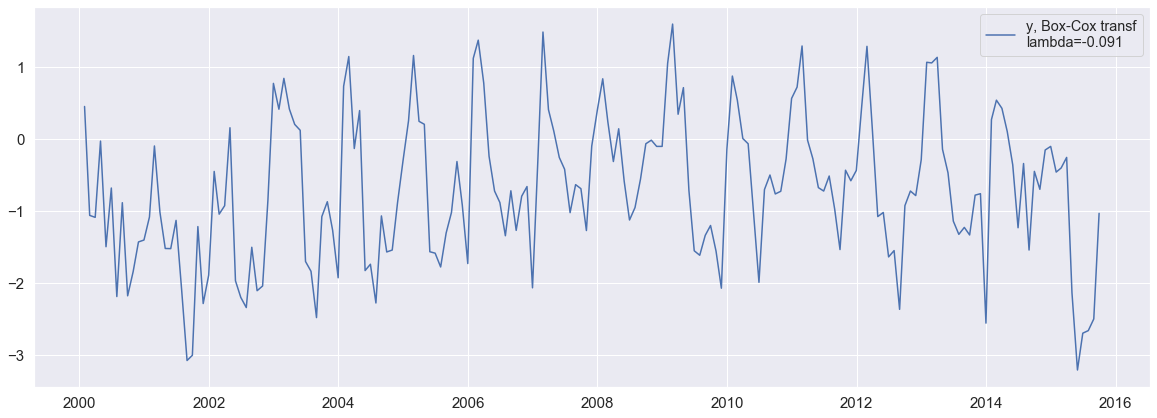

In [30]:
plt.figure(figsize=(20,7))
plt.plot(train.index, train['y_box'], label=f'y, Box-Cox transf\nlambda={round(LMBDA, 3)}')
plt.legend(loc='best', fontsize='large')
plt.tick_params(labelsize=15)
plt.show()

Reduce seasonal impact

In [162]:
train.loc[:, 'y_box_diff12'] = train.loc[:, 'y_box'] - train.loc[:,'y_box'].shift(12)

In [90]:
print("Dickey-Fuller test:")

p = sm.tsa.stattools.adfuller(train['y_box_diff12'][12:])[1]

if p >= ALPHA:
    print(f"Time series is nonstationary since p-value={p} > {ALPHA}")
else:
    print(f"Time series is stationary since p-value={p} < {ALPHA}")

Dickey-Fuller test:
Time series is stationary since p-value=0.001475119196847465 < 0.05


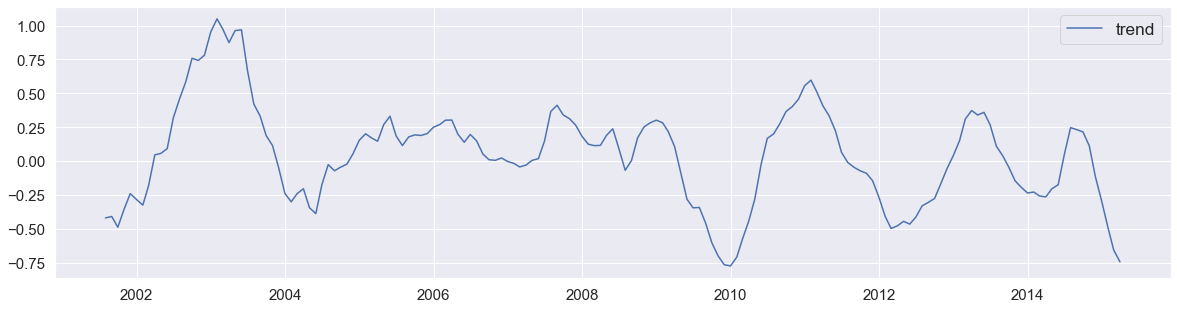

In [34]:
decomp = sm.tsa.seasonal_decompose(train['y_box_diff12'][12:], period=12)

plt.figure(figsize=(20,5))
plt.plot(decomp.trend, label='trend')
plt.legend(loc='best', fontsize='x-large')
plt.tick_params(labelsize=15)

plt.show()

Trend seems to be good

**ACF and PACF**

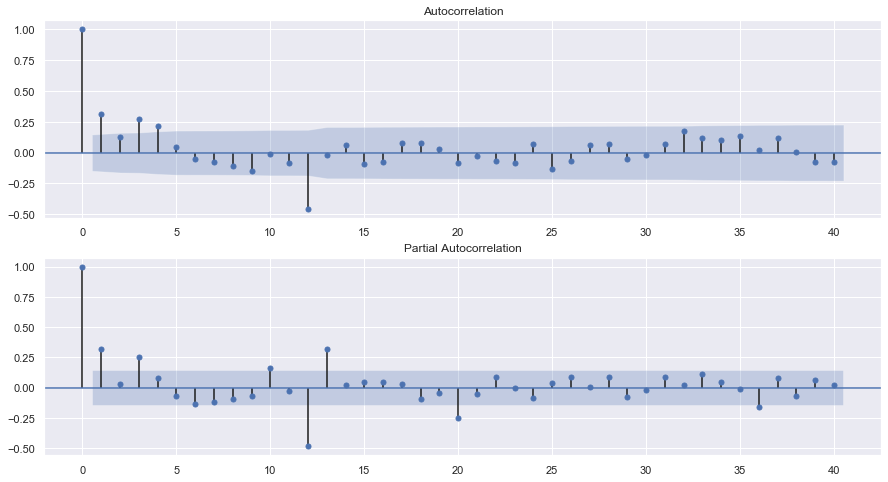

In [35]:
plt.figure(figsize=(15,8))

ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(train['y_box_diff12'][12:].values.squeeze(), lags=40, ax=ax)

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(train['y_box_diff12'][12:].values.squeeze(), lags=40, ax=ax)

plt.show()

Reasonable parameters (maybe a bit conservative but i think it's okay to prevent from overfitting)

Using ACF:

    q = 4, Q = 1

Using PACF:

    p = 3, P = 3

In [36]:
ps = range(0, 4)
Ps = range(0, 4)
qs = range(0, 5)
Qs = range(0, 2)
ds = range(0, 1)
Ds = range(1, 2)

In [37]:
parameters = itertools.product(ps, ds, qs, Ps, Ds, Qs)
parameters_list = list(parameters)
len(parameters_list)

160

Choose the best combination based on AIC

In [38]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in tqdm(parameters_list):
    try:
        model = sm.tsa.statespace.SARIMAX(train['y_box'], order=(param[0], param[1], param[2]), 
                                         seasonal_order=(param[3], param[4], param[5], 12)) \
                                        .fit(disp=False, maxiter=1000)
        results.append([param[0], param[1], param[2], param[3], param[4], param[5], model.aic])
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Look at top-5

In [39]:
result_table = pd.DataFrame(results, columns=['p', 'd', 'q', 'P', 'D', 'Q', 'aic'])
result_table = result_table.sort_values(by = 'aic', ascending=True)
print(result_table.head())
#3  0.0  2.0  2.0  1.0  1.0  376.763884

     p    d    q    P    D    Q         aic
282  3  0.0  2.0  2.0  1.0  1.0  376.763884
154  1  0.0  4.0  2.0  1.0  1.0  377.584186
286  3  0.0  2.0  3.0  1.0  1.0  378.587767
278  3  0.0  2.0  1.0  1.0  1.0  378.628018
298  3  0.0  3.0  2.0  1.0  1.0  378.740989


In [40]:
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                y_box   No. Observations:                  189
Model:             SARIMAX(3, 0, 2)x(2, 1, [1], 12)   Log Likelihood                -179.382
Date:                              Tue, 19 May 2020   AIC                            376.764
Time:                                      00:05:07   BIC                            405.349
Sample:                                  01-31-2000   HQIC                           388.357
                                       - 09-30-2015                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6197      0.153     10.601      0.000       1.320       1.919
ar.L2         -1.27

Forecast on test

In [91]:
yhat_arima = invboxcox(best_model.predict(start=len(train), end=PREDICTIONS+len(train)-1), LMBDA)
forecast_df['sarima'] = yhat_arima.to_numpy()

In [92]:
l = {}
for k, v in get_metrics(test['y'].to_numpy(), yhat_arima).items():
    print(f"{k}: {v}")
    l[k] = v
    metrics_d['sarima'] = l

#when d=1 is forced and search best combination
#MAE: 0.24257473107556474
#RMSE: 0.3091285870694779

RMSE: 0.48969340700383096
MAE: 0.33421886502925924
MAPE: 0.6221680058275126


**Save model**

In [43]:
joblib.dump(best_model, os.path.join('models', 'sarima.pkl'))
#joblib.load(os.path.join('models', 'sarima.pkl'))

['models/sarima.pkl']

Look at residuals

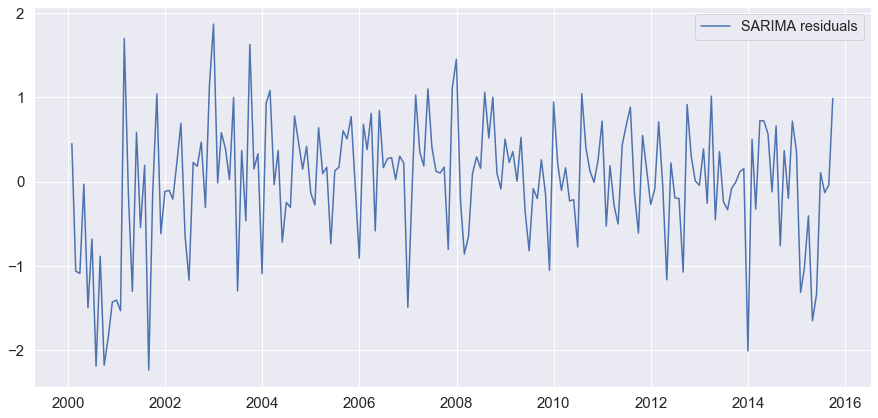

In [44]:
plt.figure(figsize=(15,7))
plt.plot(best_model.resid, label='SARIMA residuals')
plt.tick_params(labelsize=15)
plt.legend(loc='best', fontsize='large')
plt.show()

Here I'd like to try auto_arima

In [45]:
import pmdarima as pm

In [46]:
model_autoarima = pm.auto_arima(train['y_box']
                                , start_p=1, start_q=1
                                , d=None
                                , max_p=4, max_q=4
                                , m=12
                                , start_P=0, start_Q=0
                                , max_P=2, max_Q=2
                                , D=None 
                                , trace=10
                                , seasonal=True
                                , error_action='ignore'  
                                , suppress_warnings=True
                                , stepwise=True)

print(model_autoarima.summary())
#SARIMAX(1, 0, 0)x(2, 0, [1], 12)

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,0,0,12) [intercept=True]; AIC=456.745, BIC=469.712, Time=0.116 seconds
Fit ARIMA(0,0,0)x(0,0,0,12) [intercept=True]; AIC=544.125, BIC=550.608, Time=0.018 seconds
Fit ARIMA(1,0,0)x(1,0,0,12) [intercept=True]; AIC=439.414, BIC=452.381, Time=0.186 seconds
New best model found (439.414 < 456.745)
Fit ARIMA(0,0,1)x(0,0,1,12) [intercept=True]; AIC=463.376, BIC=476.343, Time=0.121 seconds
Fit ARIMA(0,0,0)x(0,0,0,12) [intercept=False]; AIC=618.131, BIC=621.373, Time=0.008 seconds
Fit ARIMA(1,0,0)x(0,0,0,12) [intercept=True]; AIC=455.240, BIC=464.965, Time=0.030 seconds
Fit ARIMA(1,0,0)x(2,0,0,12) [intercept=True]; AIC=403.417, BIC=419.626, Time=0.406 seconds
New best model found (403.417 < 439.414)
Fit ARIMA(1,0,0)x(2,0,1,12) [intercept=True]; AIC=403.339, BIC=422.790, Time=0.720 seconds
New best model found (403.339 < 403.417)
Fit ARIMA(1,0,0)x(1,0,1,12) [intercept=True]; AIC=408.969, BIC=425.178, Time=0.387 seconds
Fit ARIMA(1,0,

In [163]:
yhat_autoarima = invboxcox(model_autoarima.predict(n_periods=PREDICTIONS), LMBDA)
y_true = test['y'].to_numpy()
forecast_df['auto_sarima'] = yhat_autoarima

In [165]:
l = {}
for k, v in get_metrics(y_true, yhat_autoarima).items():
    print(f"{k}: {v}")
    l[k] = v
    metrics_d['auto_sarima'] = l

RMSE: 0.264765320025795
MAE: 0.21560588529225097
MAPE: 0.42757551330146953


**Save model**

In [49]:
joblib.dump(model_autoarima, os.path.join('models', 'auto_sarima.pkl'))
#joblib.load(os.path.join('models', 'auto_sarima.pkl'))

['models/auto_sarima.pkl']

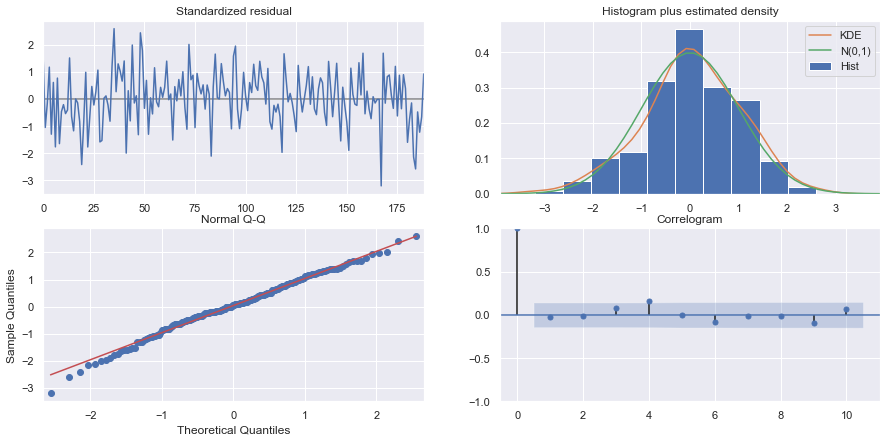

In [50]:
model_autoarima.plot_diagnostics(figsize=(15,7))
plt.show()

Residuals of auto arima looks really good. So i guess it can be considered as a good model

**Check suitability of auto sarima and sarima by hand to actual values**

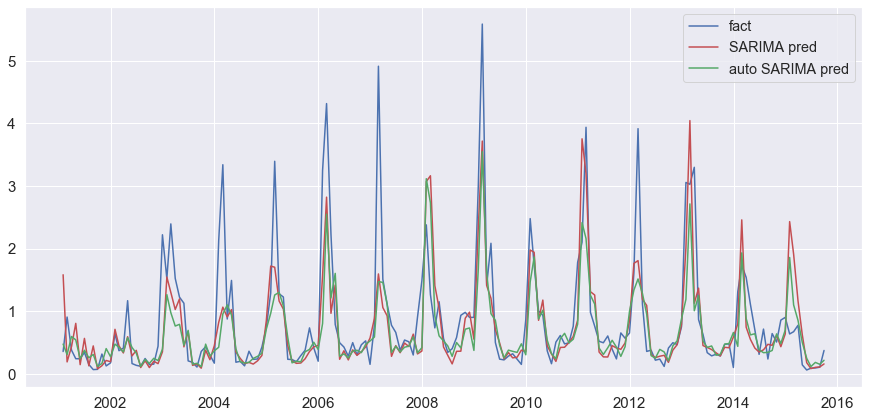

In [57]:
yhat_arima = invboxcox(best_model.fittedvalues, LMBDA)
yhat_autoarima = invboxcox(train['y_box']-model_autoarima.resid(), LMBDA)

plt.figure(figsize=(15,7))
plt.plot(train.index[12:], train['y'][12:], label='fact')
plt.plot(train.index[12:], yhat_arima[12:], color='r', label='SARIMA pred')
plt.plot(train.index[12:], yhat_autoarima[12:], color='g', label='auto SARIMA pred')
plt.legend(loc='best', fontsize='large')
plt.tick_params(labelsize=15)
plt.show()

### Holt-Winters 

In [58]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [59]:
train, test = ts_monthly[:-PREDICTIONS], ts_monthly[-PREDICTIONS:]
model_holtwint = ExponentialSmoothing(train, trend='add', seasonal='mul', seasonal_periods=12)
model_holtwint = model_holtwint.fit(use_brute=True, optimized=True)
yhat_holtwint = model_holtwint.predict(start=test.index[0], end=test.index[-1])
forecast_df['holt-winters'] = yhat_holtwint.to_numpy()

In [60]:
l = {}
for k, v in get_metrics(test['y'].to_numpy(), yhat_holtwint).items():
    print(f"{k}: {v}")
    l[k] = v
    metrics_d['holt-winters'] = l

RMSE: 0.35190661276870683
MAE: 0.25723571572565834
MAPE: 0.49546029629723504


**Save model**

In [61]:
joblib.dump(model_holtwint, os.path.join('models', 'holt_winters.pkl'))
#joblib.load(os.path.join('models', 'holt_winters.pkl'))

['models/holt_winters.pkl']

### Plot forecasting and fact

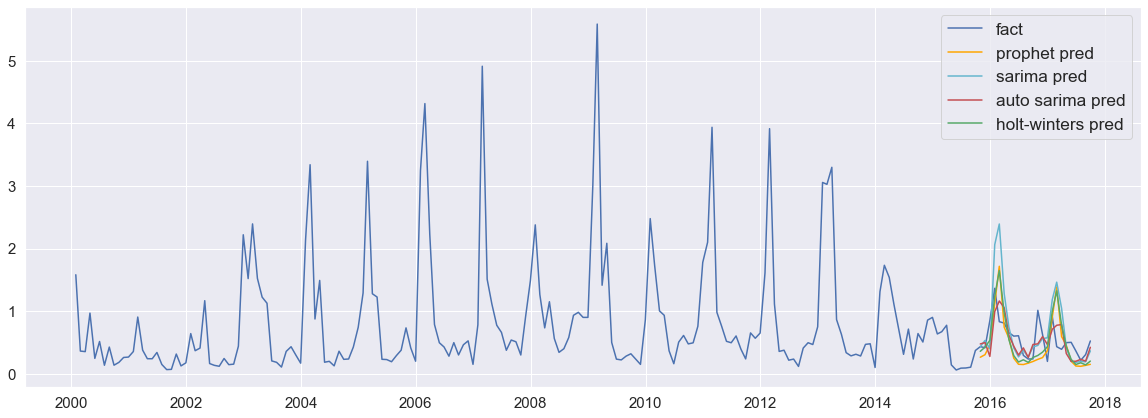

In [62]:
date_list = ts_monthly.index[-PREDICTIONS:]

#reindex to get data
forecast_df.index = date_list

plt.figure(figsize=(20,7))

plt.plot(ts_monthly.index, ts_monthly['y'].to_numpy(), label='fact')
plt.plot(date_list, forecast_df['prophet'], color='orange', label='prophet pred')
plt.plot(date_list, forecast_df['sarima'], color='c', label='sarima pred')
plt.plot(date_list, forecast_df['auto_sarima'], color='r', label='auto sarima pred')
plt.plot(date_list, forecast_df['holt-winters'], color='g', label='holt-winters pred')
plt.tick_params(labelsize=15)

plt.legend(loc='best', fontsize='x-large')
plt.show()

Look at only test

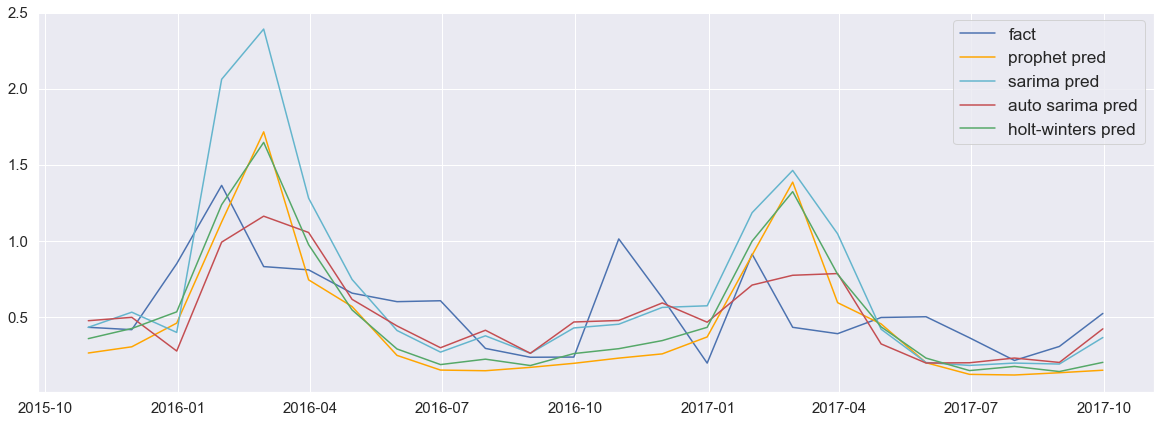

In [63]:
plt.figure(figsize=(20,7))

plt.plot(date_list, forecast_df['actual'], label='fact')
plt.plot(date_list, forecast_df['prophet'], color='orange', label='prophet pred')
plt.plot(date_list, forecast_df['sarima'], color='c', label='sarima pred')
plt.plot(date_list, forecast_df['auto_sarima'], color='r', label='auto sarima pred')
plt.plot(date_list, forecast_df['holt-winters'], color='g', label='holt-winters pred')
plt.tick_params(labelsize=15)

plt.legend(loc='best', fontsize='x-large')
plt.show()

Look at metrics

In [65]:
xx = pd.DataFrame(columns=list(metrics_d['prophet'].keys()), index=list(metrics_d.keys()))

for k, v in metrics_d.items():
    for kk, vv in v.items():
        xx.loc[k, kk] = vv
        
xx.sort_values(by=['RMSE'])

,RMSE,MAE,MAPE
auto_sarima,0.264765,0.215606,0.427576
holt-winters,0.351907,0.257236,0.49546
prophet,0.379968,0.280261,0.53791
sarima,0.489693,0.334219,0.622168


It seems that SARIMA is better than prophet and holt-winters models.
<br>
I think goodness of fit can be better if there's no so sharp jump for test part after train one

### LSTM

Now I'd like to try LSTM for forecasting monthly data
<br>
I'll take the same part of data as I used for previous models

In [67]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, Bidirectional
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

In [70]:
def create_dataset(data, n_steps=1):
    '''Preparation data for LSTM model
    
    Parameters:
        data - numpy array
        n_steps - number of previous time steps to use as input variables to predict the next time period 
        
    Return:
        prepared data in a view X array and Y array
    '''
    
    X, y = [], []
    
    for i in range(len(data)-n_steps):
        a = data[i:i+n_steps]
        X.append(a)
        y.append(data[i + n_steps])
        
    return np.array(X), np.array(y)

In [93]:
train = ts_monthly[:-PREDICTIONS]
test = ts_monthly[-PREDICTIONS:]

In [94]:
#since lstm is sensitive to the scale, need to to transform
scaler = MinMaxScaler() #better than StandardScaler
train_sc = scaler.fit_transform(train)
test_sc = scaler.transform(test)

In [95]:
n_steps = 1
Xtrain, ytrain = create_dataset(train_sc, n_steps)
Xtest, ytest = create_dataset(test_sc, n_steps)

In [96]:
n_features = 1
Xtrain = Xtrain.reshape(Xtrain.shape[0], Xtrain.shape[1], n_features)
Xtest = Xtest.reshape(Xtest.shape[0], Xtest.shape[1], n_features)

In [ ]:
%%skip
#just save for myself it here not to lose
'''
def objective(trial):
    
    model = Sequential()
    
    n_layers = trial.suggest_int("n_layers", 1, 3)
    hidden_units = []

    for i in range(n_layers):
        n_units = trial.suggest_int(f"n_units_l{i}", 1, 128)
        hidden_units.append(n_units)
     
    #needs to fix
    #for i, n in enumerate(hidden_units):
    #    if not i and i + 1 == len(hidden_units):
    #        model.add(LSTM(n, activation='relu', return_sequences=False
    #                       , input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
    #    elif not i and i + 1 != len(hidden_units):
    #        model.add(LSTM(n, activation='relu', return_sequences=True
    #                       , input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
    #    elif i + 1 != len(hidden_units):
    #        model.add(LSTM(n, activation='relu', return_sequences=False))
    #    else:
    #        model.add(LSTM(n, activation='relu', return_sequences=True))
    
    if len(hidden_units) == 1:
        
        model.add(LSTM(hidden_units[0], activation='relu', return_sequences=False
                           , input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
        
        d = trial.suggest_uniform(f"drop", 0, 0.2)
        model.add(Dropout(d))
        
    elif len(hidden_units) == 2:
        
        model.add(LSTM(hidden_units[0], activation='relu', return_sequences=True
                           , input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
        
        d = trial.suggest_uniform(f"drop", 0, 0.2)
        model.add(Dropout(d))
        
        model.add(LSTM(hidden_units[1], activation='relu', return_sequences=False))
                  
    elif len(hidden_units) == 3:
                  
        model.add(LSTM(hidden_units[0], activation='relu', return_sequences=True
                           , input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
        
        d = trial.suggest_uniform(f"drop", 0, 0.2)
        model.add(Dropout(d))
        
        model.add(LSTM(hidden_units[1], activation='relu', return_sequences=True))
    
        d = trial.suggest_uniform(f"drop", 0, 0.2)
        model.add(Dropout(d))
        
        model.add(LSTM(hidden_units[2], activation='relu', return_sequences=False))
                
    
            
    optimizer = Adam(learning_rate=trial.suggest_loguniform("adam_lr", 1e-5, 1e-1))
    
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse')
    
    history = model.fit(Xtrain, ytrain, epochs=200, batch_size=32, shuffle=False, use_multiprocessing=True
                       , validation_data=(Xtest, ytest), verbose=0)
    
    yhat_test = model.predict(Xtest)
    #inverse to got true values
    yhat_test = scaler.inverse_transform(yhat_test)

    mse = mean_squared_error(test['y'].to_numpy()[1:], yhat_test.squeeze())
    
    return mse
    
study = optuna.create_study(direction='minimize', pruner=optuna.pruners.SuccessiveHalvingPruner())
study.optimize(objective, n_trials=10, show_progress_bar=True)
'''

In [73]:
np.random.seed(SEED)

model_lstm = Sequential()
opt = Adam(learning_rate=0.001)

#LSTM
model_lstm.add(LSTM(30, activation='relu', return_sequences=True
                    , input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
model_lstm.add(LSTM(5, activation='relu'))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer=opt, loss='mse')

In [75]:
history = model_lstm.fit(Xtrain, ytrain, epochs=200, batch_size=32, shuffle=False, use_multiprocessing=True
                   , validation_data=(Xtest, ytest), verbose=0)

In [76]:
yhat_train_lstm = model_lstm.predict(Xtrain)
yhat_test_lstm = model_lstm.predict(Xtest)
#inverse to got true values
yhat_train_lstm = scaler.inverse_transform(yhat_train_lstm)
yhat_test_lstm = scaler.inverse_transform(yhat_test_lstm)

#since we reshaped data so now it needs preprocessed a bit
forecast_df['lstm'] = [np.nan] + list(yhat_test_lstm.squeeze())

In [97]:
l = {}
for k, v in get_metrics(test['y'].to_numpy()[1:], yhat_test_lstm.squeeze()).items():
    print(f"{k}: {v}")
    l[k] = v
    metrics_d['lstm'] = l

RMSE: 0.32483263600747564
MAE: 0.2711452650926689
MAPE: 0.6166003398878023


**Save model**

In [98]:
joblib.dump(model_lstm, os.path.join('models', 'lstm.pkl'))
#joblib.load(os.path.join('models', 'lstm.pkl'))

['models/lstm.pkl']

**BiLSTM**

Try the same parameters as I got best for LSTM

In [140]:
np.random.seed(SEED)

model_bilstm = Sequential()
opt = Adam(learning_rate=0.001)
#BiLSTM
model_bilstm.add(Bidirectional(LSTM(30, activation='relu', return_sequences=True
                                , input_shape=(Xtrain.shape[1], Xtrain.shape[2]))))
model_bilstm.add(Bidirectional(LSTM(5, activation='relu')))
model_bilstm.add(Dense(1))
model_bilstm.compile(optimizer=opt, loss='mse')

In [141]:
history = model_bilstm.fit(Xtrain, ytrain, epochs=200, batch_size=32, shuffle=False, use_multiprocessing=True
                   , validation_data=(Xtest, ytest), verbose=0)

In [145]:
yhat_train_bilstm = model_bilstm.predict(Xtrain)
yhat_test_bilstm = model_bilstm.predict(Xtest)
#inverse to got true values
yhat_train_bilstm = scaler.inverse_transform(yhat_train_bilstm)
yhat_test_bilstm = scaler.inverse_transform(yhat_test_bilstm)

#since we reshaped data so now it needs preprocessed a bit
forecast_df['bilstm'] = [np.nan] + list(yhat_test_bilstm.squeeze())

In [146]:
l = {}
for k, v in get_metrics(test['y'].to_numpy()[1:], yhat_test_bilstm.squeeze()).items():
    print(f"{k}: {v}")
    l[k] = v
    metrics_d['bilstm'] = l

RMSE: 0.30775717264914676
MAE: 0.26252569358310035
MAPE: 0.6282214495035117


Got metrics a little better than ordinary LSTM but it really depends on SEED in this case so basically BiLSTM and uni-LSTM seems to give almost the same results

**Save model**

In [525]:
joblib.dump(model_bilstm, os.path.join('models', 'bilstm.pkl'))
#joblib.load(os.path.join('models', 'bilstm.pkl'))

['models/bilstm.pkl']

In [148]:
print(train.shape, test.shape)
print(yhat_train_bilstm.shape, yhat_test_bilstm.shape)

(189, 1) (24, 1)
(188, 1) (23, 1)


**Look how predicted values by LSTM and BiLSTM fitted to actual data**

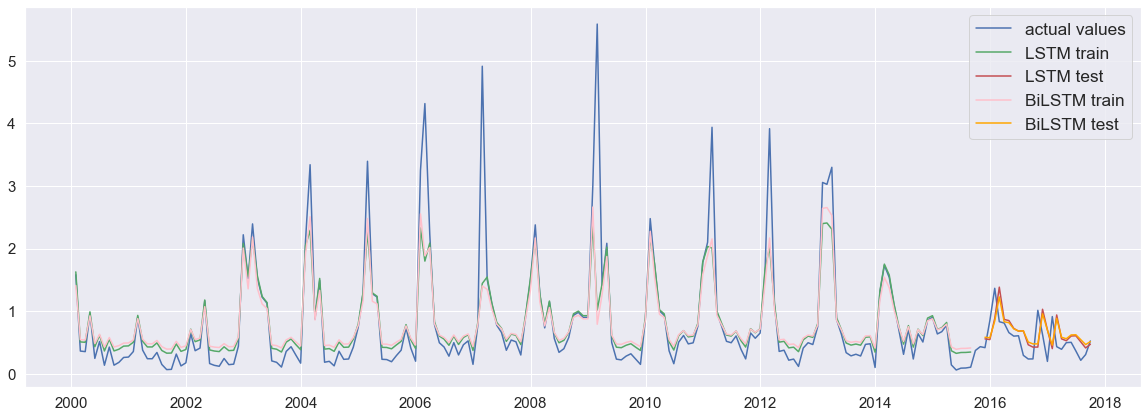

In [149]:
plt.figure(figsize=(20, 7))
plt.plot(ts_monthly, label='actual values')

plt.plot(ts_monthly.index[:-PREDICTIONS-n_steps], yhat_train_lstm, color='g', label='LSTM train')
plt.plot(ts_monthly.index[-PREDICTIONS+n_steps:], yhat_test_lstm, color='r', label='LSTM test')

plt.plot(ts_monthly.index[:-PREDICTIONS-n_steps], yhat_train_bilstm, color='pink', label='BiLSTM train')
plt.plot(ts_monthly.index[-PREDICTIONS+n_steps:], yhat_test_bilstm, color='orange', label='BiLSTM test')

plt.legend(loc='best', fontsize='x-large')
plt.tick_params(labelsize=15)
plt.show()

I tried different combinations of parametrs. All results are about above one. Of course some bayesian optimization can be used to find optimal combination of layers, neurons and other parameters but anyway ordinary arima seems to be better.

Look at metrics all in all

In [150]:
xx = pd.DataFrame(columns=list(metrics_d['prophet'].keys()), index=list(metrics_d.keys()))

for k, v in metrics_d.items():
    for kk, vv in v.items():
        xx.loc[k, kk] = vv
        
xx.sort_values(by=['RMSE'])

,RMSE,MAE,MAPE
auto_sarima,0.264765,0.215606,0.427576
bilstm,0.307757,0.262526,0.628221
lstm,0.324833,0.271145,0.6166
holt-winters,0.351907,0.257236,0.49546
prophet,0.379968,0.280261,0.53791
sarima,0.489693,0.334219,0.622168


**Winner**.

Famous SARIMA seems to be best based on test's metrics

### Plot forecasting and fact of best NN model and ordinary model

In [ ]:

plt.plot(train.index[12:], train['y'][12:], label='fact')
plt.plot(train.index[12:], yhat_arima[12:], color='r', label='SARIMA pred')

plt.legend(loc='best', fontsize='large')
plt.tick_params(labelsize=15)
plt.show()

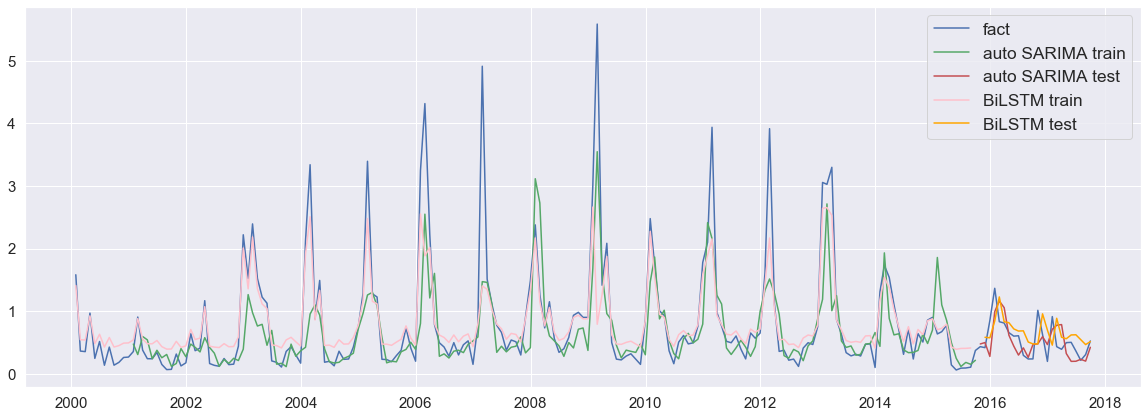

In [157]:
plt.figure(figsize=(20,7))

plt.plot(ts_monthly.index, ts_monthly['y'].to_numpy(), label='fact')

y_box, LMBDA = stats.boxcox(train.loc[:, 'y'])
yhat_autoarima = invboxcox(y_box-model_autoarima.resid(), LMBDA)
plt.plot(train.index[12:], yhat_autoarima[12:], color='g', label='auto SARIMA train')
plt.plot(forecast_df.index, forecast_df['auto_sarima'], color='r', label='auto SARIMA test')

plt.plot(ts_monthly.index[:-PREDICTIONS-n_steps], yhat_train_bilstm, color='pink', label='BiLSTM train')
plt.plot(ts_monthly.index[-PREDICTIONS+n_steps:], yhat_test_bilstm, color='orange', label='BiLSTM test')

plt.tick_params(labelsize=15)

plt.legend(loc='best', fontsize='x-large')
plt.show()

Look deeper, test only

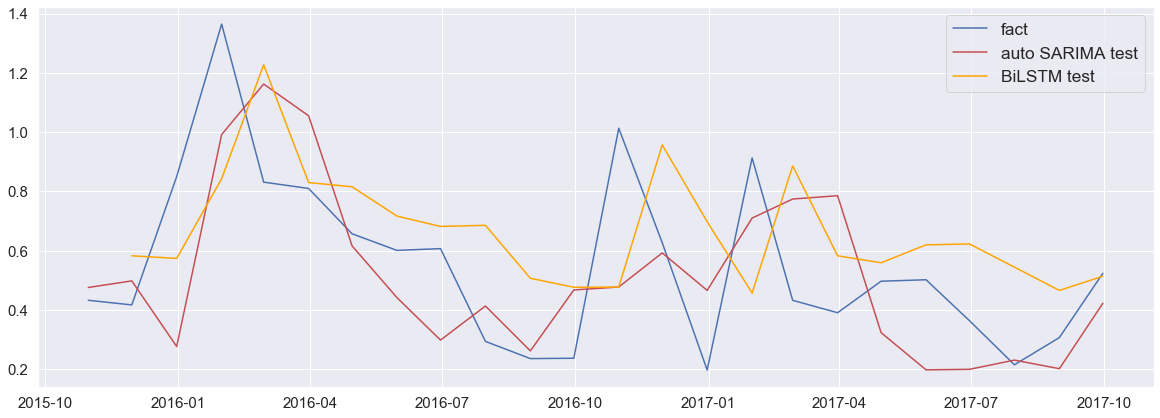

In [156]:
plt.figure(figsize=(20,7))

plt.plot(forecast_df.index, forecast_df['actual'], label='fact')
plt.plot(forecast_df.index, forecast_df['auto_sarima'], color='r', label='auto SARIMA test')
plt.plot(forecast_df.index[n_steps:], forecast_df['bilstm'][1:], color='orange', label='BiLSTM test')

plt.tick_params(labelsize=15)

plt.legend(loc='best', fontsize='x-large')
plt.show()

**Conclusion**:

SARIMA beats other models based on metrics but from my point of view BiLSTM looks more real, it repeats movements of actual series and biased a little, so adding some constant value i think can solve the case.

Also, maybe if test has less points then BiLSTM (LSTM) would be the winner. Because in real life first of all it can be interested in value in next point like month here. So, anyway I'd prefer BiLSTM in this case